# Generating intra-day trading signals

## Imports & Settings

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
%matplotlib inline

import sys, os
from time import time

import numpy as np
import pandas as pd

from scipy.stats import spearmanr
import lightgbm as lgb

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import format_time

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load Model Data

In [4]:
data = pd.read_hdf('hf_data.h5', 'model_data')

In [5]:
dates = data.index.get_level_values('date_time').date
for i in range(1, 11):
    data[f'ret{i}min'] = data.groupby(['ticker', dates])[f'ret{i}min'].shift()

In [6]:
data = data.dropna(subset=['fwd1min'])

In [7]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 47691042 entries, ('AAL', Timestamp('2014-12-22 09:30:00')) to ('YHOO', Timestamp('2017-06-16 15:59:00'))
Data columns (total 21 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   minute          47691042 non-null  int64  
 1   ret1min         45195496 non-null  float64
 2   ret2min         45055629 non-null  float64
 3   ret3min         44933477 non-null  float64
 4   ret4min         44810314 non-null  float64
 5   ret5min         44684180 non-null  float64
 6   ret6min         44554887 non-null  float64
 7   ret7min         44428726 non-null  float64
 8   ret8min         44308529 non-null  float64
 9   ret9min         44181609 non-null  float64
 10  ret10min        44056812 non-null  float64
 11  fwd1min         47691042 non-null  float64
 12  price           47691042 non-null  float64
 13  rup             46587774 non-null  float64
 14  rdown           46554610 non-null  flo

In [8]:
data.to_hdf('hf_data.h5', 'model_data')

## Model Training

In [9]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates[self.date_idx] <= days[train_end])].index
            test_idx = dates[(dates[self.date_idx] > days[test_start])
                             & (dates[self.date_idx] <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


In [10]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

### Categorical Variables

In [11]:
data['stock_id'] = pd.factorize(data.index.get_level_values('ticker'), sort=True)[0]

In [12]:
categoricals = ['minute', 'stock_id']

### Custom Metric

In [13]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

In [14]:
label = sorted(data.filter(like='fwd').columns)
features = data.columns.difference(label).tolist()
label = label[0]

In [15]:
params = dict(boosting='gbdt',
              objective='regression',
              metric='None',
              verbose=-1)

In [16]:
num_boost_round = 250

In [17]:
DAY = 390   # minuts; 6.5 hrs (9:30 - 15:59)
MONTH = 21  # trading days

In [18]:
n_splits = 24

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          lookahead=1,
                          test_period_length=MONTH * DAY,
                          train_period_length=12 * MONTH * DAY,
                          date_idx='date_time')

In [19]:
store='hf_model.h5'

In [ ]:
for i, (train_idx, test_idx) in enumerate(cv.split(X=data)):
    train_dates = data.iloc[train_idx].index.unique('date_time')
    test_dates = data.iloc[test_idx].index.unique('date_time')
    print(train_dates.min(), train_dates.max(), test_dates.min(), test_dates.max())

In [20]:
lgb_data = lgb.Dataset(data=data.drop(label, axis=1),
                       label=data[label],
                       categorical_feature=categoricals,
                       free_raw_data=False)

In [35]:
cv_preds = [cv_preds]

In [ ]:
T = 0
cv_preds = []
for i, (train_idx, test_idx) in enumerate(cv.split(X=data)):
    start = time()
    if i < 5: continue
    t = time() - start
    lgb_train = lgb_data.subset(train_idx.tolist()).construct()
    lgb_test = lgb_data.subset(test_idx.tolist()).construct()
    model = lgb.train(params=params,
                      train_set=lgb_train,
                      valid_sets=[lgb_train, lgb_test],
                      feval=ic_lgbm,
                      num_boost_round=num_boost_round,
                      early_stopping_rounds=50,
                      verbose_eval=50)
    if i == 0:
        fi = get_fi(model).to_frame()
    else:
        fi[i] = get_fi(model)
    print(fi[i].nlargest(5))

    test_set = data.iloc[test_idx, :]
    X_test = test_set.loc[:, model.feature_name()]
    y_test = test_set.loc[:, label]
    y_pred = model.predict(X_test)
    
    cv_preds.append(y_test
                    .to_frame('y_test')
                    .assign(y_pred=y_pred).assign(i=i))
    
cv_preds = pd.concat(cv_preds)

ic_by_day.to_hdf(store, 'daily_ic')
fi.to_hdf(store, 'fi')
cv_preds.to_hdf(store, 'predictions')

## Signal Evaluation

In [24]:
cv_preds.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3227082 entries, ('AAL', Timestamp('2017-11-30 09:30:00')) to ('XRAY', Timestamp('2017-09-29 15:19:00'))
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   y_test  3227082 non-null  float64
 1   y_pred  3227082 non-null  float64
 2   i       3227082 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 83.3+ MB


### Information Coefficient

In [77]:
by_day = cv_preds.groupby(cv_preds.index.get_level_values('date_time').date)
ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x.y_pred)[0])

daily_ic_mean = ic_by_day.mean()
daily_ic_median = ic_by_day.median()

ic = spearmanr(cv_preds.y_test, cv_preds.y_pred)[0]

print(f'\n{ic:6.2%} | {daily_ic_mean: 6.2%} | {daily_ic_median: 6.2%}')


 1.90% |  1.98% |  1.91%


### Compute signal quantiles

In [ ]:
dates = cv_preds.index.get_level_values('date_time').date

In [38]:
cv_preds['decile'] = (cv_preds.groupby(dates, group_keys=False)
                      .apply(lambda x: pd.qcut(x.y_pred, q=10, labels=list(range(1, 11)))))

In [39]:
cv_preds['quintile'] = (cv_preds.groupby(dates, group_keys=False)
                      .apply(lambda x: pd.qcut(x.y_pred, q=5, labels=list(range(1, 6)))))

### Return Statistics by Quantile

In [48]:
ret_stats_5 = cv_preds.groupby('quintile').y_test.describe()
ret_stats_5

,count,mean,std,min,25%,50%,75%,max
quintile,,,,,,,,
1,3789631.0,-1.393970e-05,0.000849,-0.062436,-0.000319,-0.000005,0.000293,0.069966
2,3789344.0,-3.759795e-06,0.000549,-0.045871,-0.000245,0.000000,0.000236,0.032385
3,3789345.0,-5.394314e-07,0.000523,-0.034013,-0.000234,0.000000,0.000231,0.031783
4,3789344.0,4.271292e-06,0.000545,-0.032158,-0.000235,0.000000,0.000242,0.067023
5,3789536.0,1.758100e-05,0.000801,-0.074215,-0.000280,0.000009,0.000311,0.045520


In [49]:
ret_stats_10 = cv_preds.groupby('decile').y_test.describe()
ret_stats_10

,count,mean,std,min,25%,50%,75%,max
decile,,,,,,,,
1,1894940.0,-1.995343e-05,0.001027,-0.062436,-0.000380,-9.469758e-06,0.000345,0.069966
2,1894691.0,-7.925179e-06,0.000621,-0.027180,-0.000270,-1.317809e-06,0.000253,0.067651
3,1894658.0,-4.578574e-06,0.000561,-0.045871,-0.000250,0.000000e+00,0.000239,0.029765
4,1894686.0,-2.941027e-06,0.000536,-0.035570,-0.000240,0.000000e+00,0.000233,0.032385
5,1894741.0,-1.129222e-06,0.000524,-0.022760,-0.000235,0.000000e+00,0.000231,0.031783
6,1894604.0,5.040185e-08,0.000522,-0.034013,-0.000233,0.000000e+00,0.000232,0.031527
7,1894642.0,2.915731e-06,0.000535,-0.020600,-0.000233,0.000000e+00,0.000238,0.067023
8,1894702.0,5.626810e-06,0.000555,-0.032158,-0.000237,9.249586e-07,0.000247,0.053167
9,1894649.0,9.261194e-06,0.000601,-0.025329,-0.000249,4.010937e-06,0.000265,0.036626


### Plot Performance by Decile

In [4]:
cv_preds= pd.read_hdf('hf_model.h5', 'predictions')

In [5]:
dates = cv_preds.index.get_level_values('date_time')
min_ret_by_decile = cv_preds.groupby(['date_time', 'decile']).y_test.mean()
cumulative_ret_by_decile = (min_ret_by_decile
                            .unstack('decile')
                            .add(1)
                            .cumprod()
                            .sub(1))

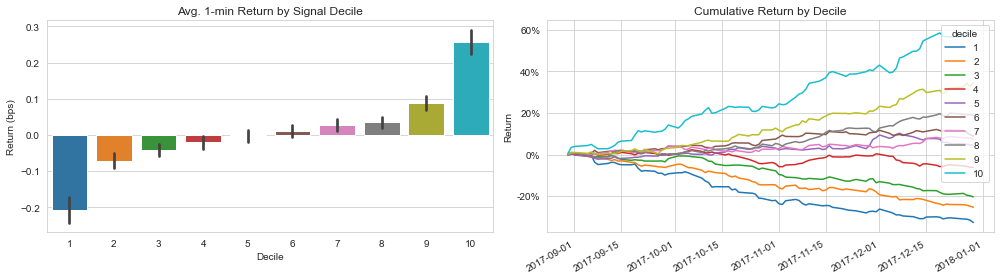

In [6]:
fig, axes = plt.subplots(figsize=(14, 4), ncols=2)

sns.barplot(y='y_test', 
            x='decile', 
            data=cv_preds.assign(y_test=cv_preds.y_test.mul(10000)), 
            ax=axes[0])
axes[0].set_title('Avg. 1-min Return by Signal Decile')
axes[0].set_ylabel('Return (bps)')
axes[0].set_xlabel('Decile')

(min_ret_by_decile
 .unstack('decile')
 .add(1)
 .cumprod()
 .sub(1)
 .resample('D')
 .last()
 .dropna()
 .sort_index()
 .plot(ax=axes[1], title='Cumulative Return by Decile'))
axes[1].yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[1].set_xlabel('')
axes[1].set_ylabel('Return')
fig.tight_layout()
fig.savefig('figures/hft_deciles', dpi=300)